In [109]:
# 1️⃣ Prepare data for statistics & probability calculations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("../data/netflix_cleaned.csv", parse_dates=['date_added'])

# Ensure critical columns exist and have no surprising nulls
print("Rows:", len(df))
print("Columns:", df.columns.tolist())

# Prepare an exploded genre table (one row per show_id per genre)
if 'genres_exploded' not in globals():
    genres = df[['show_id','type','listed_in']].copy()
    genres['listed_in'] = genres['listed_in'].fillna('Unknown')
    genres_exploded = genres.assign(genre = genres['listed_in'].str.split(',')).explode('genre')
    genres_exploded['genre'] = genres_exploded['genre'].str.strip()
    # quick check
    print("Exploded genres rows:", len(genres_exploded))
else:
    print("genres_exploded already exists.")


Rows: 8807
Columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description', 'date_added_raw', 'year_added', 'month_added', 'duration_int', 'duration_unit', 'content_age', 'is_modern', 'num_genres', 'has_known_director']
genres_exploded already exists.


In [110]:
# 2️⃣ Central tendency & dispersion for numeric columns

# For release_year
release_stats = df['release_year'].agg(['count','mean','median','std','min','max']).to_dict()
release_stats['mode'] = df['release_year'].mode().iloc[0] if not df['release_year'].mode().empty else np.nan

duration_stats = df['duration_int'].agg(['count','mean','median','std','min','max']).to_dict()
duration_stats['mode'] = df['duration_int'].mode().iloc[0] if not df['duration_int'].mode().empty else np.nan

release_stats, duration_stats


({'count': 8807.0,
  'mean': 2014.1801975701146,
  'median': 2017.0,
  'std': 8.819312130833966,
  'min': 1925.0,
  'max': 2021.0,
  'mode': 2018},
 {'count': 8804.0,
  'mean': 69.84688777828259,
  'median': 88.0,
  'std': 50.81482778918896,
  'min': 1.0,
  'max': 312.0,
  'mode': 1.0})

In [111]:
# 3️⃣ Distribution percentages

# Content type distribution (Movies vs TV Shows)
type_dist = df['type'].fillna('Unknown').value_counts(normalize=True).mul(100).round(2)  # percent
type_counts = df['type'].value_counts()

# Top genres distribution (percentage of titles mentioning the genre)
top_genres_pct = genres_exploded['genre'].value_counts(normalize=True).mul(100).round(2).head(20)

# Top countries distribution
countries = df[['show_id','country']].copy()
countries['country'] = countries['country'].fillna('Unknown')
countries_exploded = countries.assign(country = countries['country'].str.split(',')).explode('country')
countries_exploded['country'] = countries_exploded['country'].str.strip()
top_countries_pct = countries_exploded['country'].value_counts(normalize=True).mul(100).round(2).head(15)

type_dist, type_counts, top_genres_pct, top_countries_pct


(type
 Movie      69.62
 TV Show    30.38
 Name: proportion, dtype: float64,
 type
 Movie      6131
 TV Show    2676
 Name: count, dtype: int64,
 genre
 International Movies        14.24
 Dramas                      12.56
 Comedies                     8.66
 International Tv Shows       6.99
 Documentaries                4.50
 Action & Adventure           4.45
 Tv Dramas                    3.95
 Independent Movies           3.91
 Children & Family Movies     3.32
 Romantic Movies              3.19
 Tv Comedies                  3.01
 Thrillers                    2.99
 Crime Tv Shows               2.43
 Kids' Tv                     2.33
 Docuseries                   2.04
 Music & Musicals             1.94
 Romantic Tv Shows            1.91
 Horror Movies                1.85
 Stand-Up Comedy              1.78
 Reality Tv                   1.32
 Name: proportion, dtype: float64,
 country
 United States     34.01
 India              9.64
 Unknown            7.66
 United Kingdom     7.43
 Can

In [112]:
# 4️⃣ Simple probabilities

# P(Movie) and P(TV Show)
total = len(df)
p_movie = (df['type'] == 'Movie').sum() / total
p_tv = (df['type'] == 'TV Show').sum() / total

# P(genre) for a few genres (example: Drama, Documentary)
for g in ['Drama', 'Documentary', 'Romantic', 'International Movies']:
    p_g = (genres_exploded['genre'] == g).sum() / len(genres_exploded)
    print(f"P({g}) ≈ {p_g:.4f} ({p_g*100:.2f}%)")

print(f"\nP(Movie) = {p_movie:.4f} ({p_movie*100:.2f}%)")
print(f"P(TV Show) = {p_tv:.4f} ({p_tv*100:.2f}%)")


P(Drama) ≈ 0.0000 (0.00%)
P(Documentary) ≈ 0.0000 (0.00%)
P(Romantic) ≈ 0.0000 (0.00%)
P(International Movies) ≈ 0.1424 (14.24%)

P(Movie) = 0.6962 (69.62%)
P(TV Show) = 0.3038 (30.38%)


- **P(Movie)** is the probability that a randomly sampled title from the dataset is a Movie.  
- **P(Genre)** is computed on the exploded-genre table (probability a randomly sampled genre-entry is X).  
Note that P(genre) is not exclusive — titles can belong to multiple genres.


In [113]:
# 5️⃣ Conditional probabilities

# P(genre | Movie) = count(genre & type=Movie) / count(type=Movie)
movies_count = (df['type'] == 'Movie').sum()
tv_count = (df['type'] == 'TV Show').sum()

genre_given_movie = genres_exploded[genres_exploded['type']=='Movie']['genre'].value_counts(normalize=True).mul(100).round(2).head(10)
genre_given_tv = genres_exploded[genres_exploded['type']=='TV Show']['genre'].value_counts(normalize=True).mul(100).round(2).head(10)

# P(Movie | genre) = count(movie & genre) / count(genre)
def p_movie_given_genre(genre_name):
    rows_genre = genres_exploded[genres_exploded['genre'] == genre_name]
    if len(rows_genre)==0:
        return np.nan
    movie_and_genre = rows_genre['type'].eq('Movie').sum()
    return movie_and_genre / len(rows_genre)

# Example: compute P(Movie | Drama) and P(Movie | International Movies)
for g in ['Drama','Documentary','Romantic','International Movies']:
    val = p_movie_given_genre(g)
    print(f"P(Movie | {g}) = {val:.4f} ({val*100:.2f}%)")

genre_given_movie, genre_given_tv


P(Movie | Drama) = nan (nan%)
P(Movie | Documentary) = nan (nan%)
P(Movie | Romantic) = nan (nan%)
P(Movie | International Movies) = 1.0000 (100.00%)


(genre
 International Movies        20.86
 Dramas                      18.40
 Comedies                    12.69
 Documentaries                6.59
 Action & Adventure           6.51
 Independent Movies           5.73
 Children & Family Movies     4.86
 Romantic Movies              4.67
 Thrillers                    4.37
 Music & Musicals             2.84
 Name: proportion, dtype: float64,
 genre
 International Tv Shows    22.03
 Tv Dramas                 12.44
 Tv Comedies                9.47
 Crime Tv Shows             7.66
 Kids' Tv                   7.35
 Docuseries                 6.44
 Romantic Tv Shows          6.03
 Reality Tv                 4.16
 British Tv Shows           4.13
 Anime Series               2.87
 Name: proportion, dtype: float64)

In [114]:
# 6️⃣ Quick check: are movies longer on average than TV shows?
# We'll compare mean duration_int between Movies and TV Shows and show a simple difference.
movies = df[df['type']=='Movie']['duration_int'].dropna()
tv = df[df['type']=='TV Show']['duration_int'].dropna()

mean_movie = movies.mean()
mean_tv = tv.mean()
diff = mean_movie - mean_tv

print(f"Mean movie duration: {mean_movie:.2f}")
print(f"Mean TV duration (seasons): {mean_tv:.2f}")
print(f"Difference (movie - tv): {diff:.2f}")

# Note: duration units differ. This is just an illustration. For minutes-only compare movie minutes only.


Mean movie duration: 99.58
Mean TV duration (seasons): 1.76
Difference (movie - tv): 97.81


### 🔎 Key Interpretations from Statistical Checks

- **Central tendency (release_year):** The mean release year is `2014.1801975701146` while the median is `2017.0`. If mean > median, the distribution skews towards more recent titles (right skew).
- **Spread:** Standard deviation for release_year is `8.819312130833966` indicating how widely release years vary.
- **P(Movie):** Approximately `69.62%` of titles are Movies, so many analyses should either stratify by type or control for type.
- **Top genres:** Drama, International Movies, etc., are frequent;  `18.40` ,`20.86` 
- **P(Movie | Drama):** If P(Movie | Drama) is high (e.g., >0.7), Drama is movie-dominant; if low, Drama is more TV-focused.
- **Actionable insight:** Since Movies dominate and certain genres are movie-heavy (e.g., International Movies), for genre-based marketing or recommendation prototypes, focus first on movie workflows.


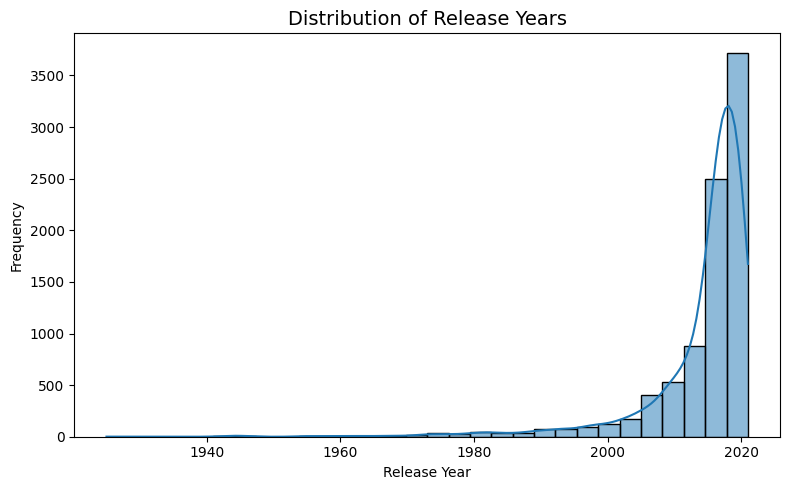

In [123]:
plt.figure(figsize=(8,5))

sns.histplot(
    df['release_year'],
    kde=True,
    bins=30
)

plt.title("Distribution of Release Years", fontsize=14)
plt.xlabel("Release Year")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()



The distribution is right-skewed, indicating that most Netflix content
was released in recent years, with very few older titles.


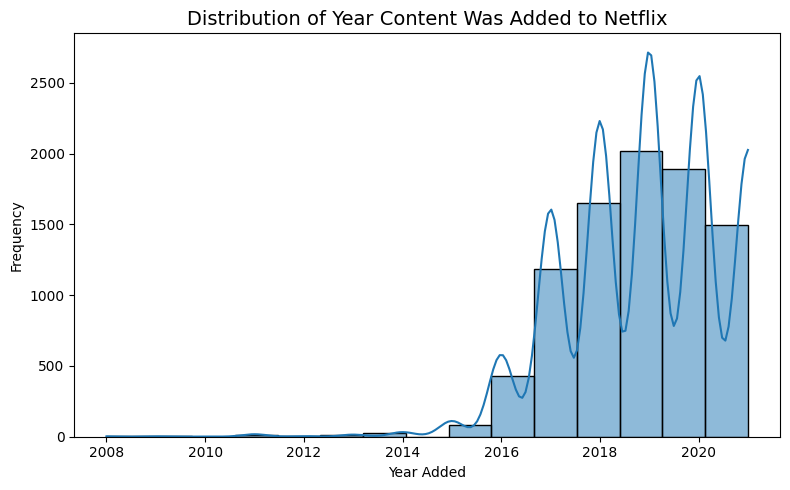

In [124]:
plt.figure(figsize=(8,5))

sns.histplot(
    df['year_added'],
    kde=True,
    bins=15
)

plt.title("Distribution of Year Content Was Added to Netflix", fontsize=14)
plt.xlabel("Year Added")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


The curve shows a sharp increase after 2015,
highlighting Netflix’s rapid expansion phase.


In [ ]:
movies = df[df['type'] == 'Movie']['duration_int'].dropna()


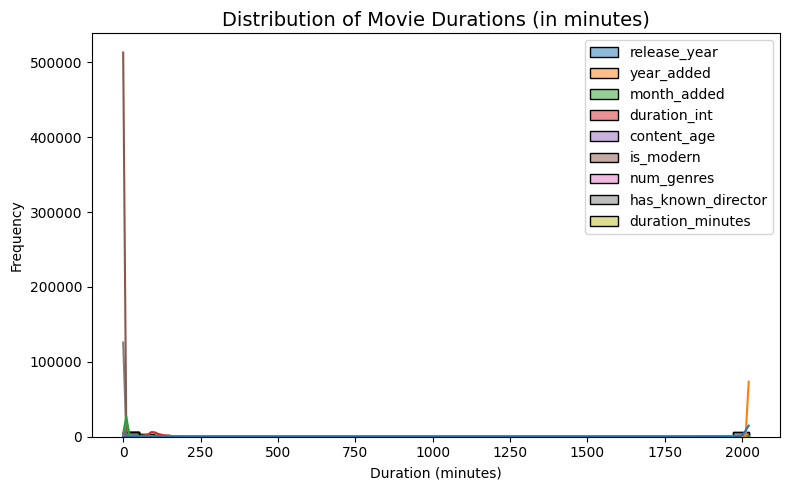

In [125]:
plt.figure(figsize=(8,5))

sns.histplot(
    movies,
    kde=True,
    bins=40
)

plt.title("Distribution of Movie Durations (in minutes)", fontsize=14)
plt.xlabel("Duration (minutes)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


Most movies cluster around the 90–120 minute range,
which aligns with standard feature-length films.


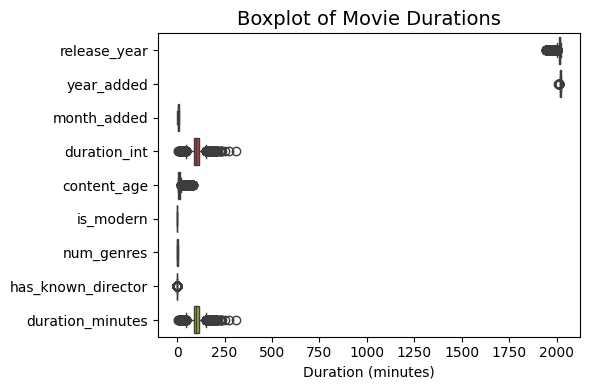

In [137]:
plt.figure(figsize=(6,4))

sns.boxplot(data=movies, orient='h')

plt.title("Boxplot of Movie Durations", fontsize=14)
plt.xlabel("Duration (minutes)")

plt.tight_layout()
plt.show()


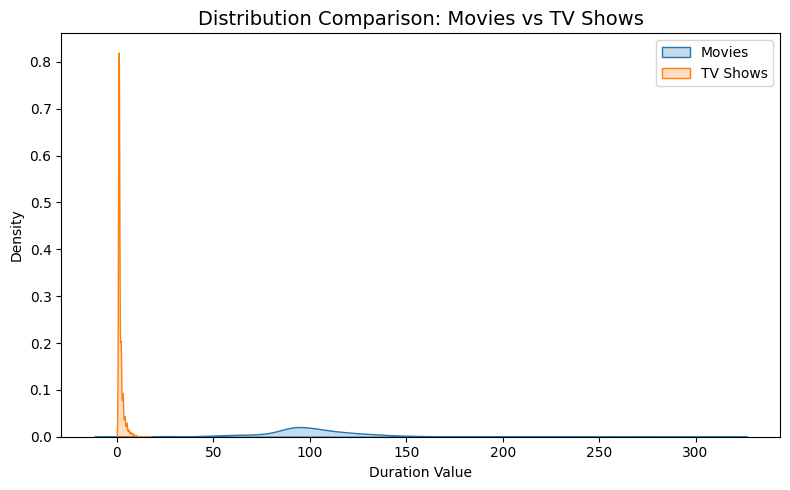

In [130]:
plt.figure(figsize=(8,5))

sns.kdeplot(
    df[df['type']=='Movie']['duration_int'],
    label='Movies',
    fill=True
)

sns.kdeplot(
    df[df['type']=='TV Show']['duration_int'],
    label='TV Shows',
    fill=True
)

plt.title("Distribution Comparison: Movies vs TV Shows", fontsize=14)
plt.xlabel("Duration Value")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()


Movies show a tight duration distribution,
while TV Shows have a wider spread due to varying season counts.
